# HW4: Shallow Water Equation

1. Implement a solver for the shallow water equations,
$$ \begin{bmatrix} h \\ h u \end{bmatrix}_t + \begin{bmatrix} hu \\ hu^2 + \frac g 2 h^2 \end{bmatrix}_x = 0 $$
where $h$ is water thickness, $hu$ is the momentum of a column of water, and $g$ is the gravitational potential.
The shallow water equations are very similar to isothermal gas dynamics except that the wave speed $c$ is not constant, but rather $\pm \sqrt{gh}$ as can be seen from the eigenvalues of the flux Jacobian.

In [117]:
import numpy
from matplotlib import pyplot
#pyplot.style.use('ggplot')

limiters = []
def limappend(lim):
    limiters.append(lim)
    return lim

@limappend
def limit_zero(r):
    return 0*r

@limappend
def limit_none(r):
    return 0*r+1

@limappend
def limit_minmod(r):
    return numpy.maximum(numpy.minimum(2*r, 2*(1-r)), 0)

@limappend
def limit_sin(r):
    return numpy.where(numpy.all((0 < r, r < 1), axis=0),
                      numpy.sin(numpy.pi*r),
                      0)
@limappend
def limit_vl(r):
    return numpy.maximum(4*r*(1-r), 0)

@limappend
def limit_bj(r):
    return numpy.clip(numpy.minimum(4*r, 4*(1-r)), 0, 1)

def rk_butcher_4():
    A = numpy.array([[0,0,0,0],[.5,0,0,0],[0,.5,0,0],[0,0,1,0]])
    b = numpy.array([1/6, 1/3, 1/3, 1/6])
    return A, b

def ode_rkexplicit(f, u0, butcher=None, tfinal=1, h1=.05):
    if butcher is None:
        A, b = rk_butcher_4()
    else:
        A, b = butcher
    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    while t < tfinal:
        if tfinal - t < 1.01*h1:
            h1 = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h1
        h1 = min(h1, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h1 * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h1*c[i], Yi)
        u += h1 * fY.dot(b)
        t = tnext
        hist.append((t, u.copy()))
    return hist

def flux_shallow(U, c):
    h = U[0]
    u = U[1] / h
    return numpy.array([U[1], U[1]*u + 9.8000/2*h**2])

def speed_c(h):
    c= numpy.sqrt(numpy.absolute(9.8000*h))
    return c

def riemann_shallow(UL, UR):
    maxit=30
    hL = UL[0]
    hR = UR[0]
    uL = UL[1] / hL
    uR = UR[1] / hR
    h = .5*(hL + hR)  # Initial guess to Newton solve

    for i in range(maxit):
        
        ujumpL = numpy.where(h > hL,
                            (hL - h) / numpy.sqrt(h*hL),    # shock
                            speed_c(h) * (numpy.log(hL) - numpy.log(h))) # rarefaction
        ujumpR = numpy.where(h > hR,
                            (hR - h) / numpy.sqrt(h*hR),    # shock
                            speed_c(h) * (numpy.log(hR) - numpy.log(h))) # rarefaction
        residual = ujumpL + ujumpR - (uR - uL)
               
        #print('{: 2d} {:10.2e} {:5f} {:5f}'.format(i, numpy.linalg.norm(residual), min(h), max(h)))
        if numpy.linalg.norm(residual) < 1e-7:
            u = uL + ujumpL
            break
        elif i+1 == maxit:
            print(h)
            raise RuntimeError('Newton solver failed to converge')
          
        
        dujumpL = numpy.where(h > hL,
                             -(1 + .5*(hL - h)/h)/numpy.sqrt(h*hL), # shock
                              -speed_c(h) / h)                                       # rarefaction
        dujumpR = numpy.where(h > hR,
                             -(1 + .5*(hR - h)/h)/numpy.sqrt(h*hR), # shock
                              -speed_c(h) / h)  # rarefaction
    
        delta_h = -residual / (dujumpL + dujumpR)
        while min(h + delta_h) <= 0:  # line search to prevent negative density
            delta_h *= .5
        h += delta_h
    U0 = numpy.zeros_like(UL)

    for i in range(len(h)):
   
        if uL[i] - speed_c(h[i]) < 0 < u[i] - speed_c(h[i]) or u[i] + speed_c(h[i]) < 0 < uR[i] + speed_c(h[i]):
            # Inside left (right) sonic rarefaction
            print("sonic rarefaction")
            U0[0,i] = numpy.exp(-(u[i] - numpy.sign(u[i])*speed_c(h[i]) - speed_c(h[i])*numpy.log(h[i]))/speed_c(h[i]))
            U0[1,i] = U0[0,i] * numpy.sign(u[i])*speed_c(h[i])
        elif ((hL[i] >= h[i] and 0 <= uL[i] - speed_c(h[i])) or
              (hL[i] < h[i] and 0 < (h[i]*u[i] - UL[1,i]))):
            print("Left rarefaction or shock is supersonic")
            # Left rarefaction or shock is supersonic
            U0[:,i] = UL[:,i]
        elif ((hR[i] >= h[i] and uR[i] + speed_c(h[i]) <= 0) or
              (hR[i] < h[i] and UR[1][i] - h[i]*u[i]) > 0):
            print("Right rarefaction or shock is supersonic")
            # Right rarefaction or shock is supersonic
            U0[:,i] = UR[:,i]
        else:
            # print("Sampling from star state")
            # Sample star state
            U0[0,i] = h[i]
            U0[1,i] = h[i]*u[i]
    
    return flux_shallow(U0, speed_c(h))

def fvsolve2system(riemann, U0, a=-10, b=10, n=22, tfinal=1., limit=limit_minmod, args = ()):
    h1 = (b - a)/n
    x = numpy.linspace(a+h1/2, b-h1/2, n) # Element midpoints (centroids)
    U0x = U0(x)
    Ushape = U0x.shape
    idxL = numpy.arange(-1, n-1)
    idxR = numpy.arange(1, n+1) % n
    def rhs(t, U):
        U = U.reshape(Ushape)
        jump = U[:,idxR] - U[:,idxL]
        r = numpy.zeros_like(jump)
        numpy.divide(U - U[:,idxL], jump, out=r, where=(jump!=0))
        g = limit(r) * jump / (2*h1)
        fluxL = riemann(U[:,idxL] + g[:,idxL] * h1/2, U - g * h1/2, *args)
        return (fluxL - fluxL[:,idxR]).flatten() / h1
    hist = ode_rkexplicit(rhs, U0x.flatten(), h1=h1/5, tfinal=tfinal)
    return x, [(t, U.reshape(Ushape)) for t, U in hist]


def riemann_shallow_hll(UL, UR):
    hL = UL[0]
    hR = UR[0]
    h= 0.5*hL+0.5*hR
    uL = UL[1] / hL
    uR = UR[1] / hR
    sL = numpy.minimum(uL - speed_c(h), uR - speed_c(h))
    sR = numpy.maximum(uL + speed_c(h), uR + speed_c(h))
    fL = flux_shallow(UL, speed_c(h))
    fR = flux_shallow(UR, speed_c(h))
    return numpy.where(sL > 0, fL,
                       numpy.where(sR < 0, fR,
                                   (sR*fL - sL*fR + sL*sR*(UR - UL)) / (sR-sL)))

def initial_shallow(x):
    return numpy.array([1 + 2*(numpy.exp(-(x*4)**2)),
                        0*x])

## Newton 

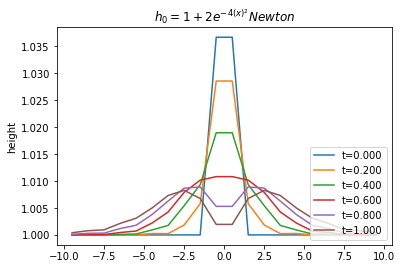

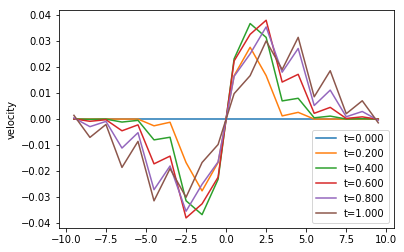

In [118]:
x, hist = fvsolve2system(riemann_shallow, initial_shallow, n=20, limit=limit_vl, args=())
pyplot.title('$h_0= 1+ 2e^{-4(x)^2} Newton$')
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')
pyplot.legend(loc='lower right');
pyplot.show()

## HLL

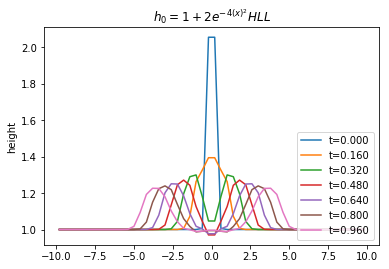

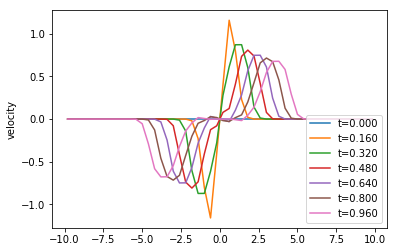

In [119]:
x, hist = fvsolve2system(riemann_shallow_hll, initial_shallow, n=50, limit=limit_vl, args=())
pyplot.title('$h_0= 1+ 2e^{-4(x)^2} HLL$')
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')
pyplot.legend(loc='lower right');
pyplot.show()

## Shocks and Rarefactions using Newton Solver

** Choose initial conditions for your numerical experiments that create all possible configurations of subsonic and supersonic shocks and rarefactions.**

**Right and Left Rarefactions or Supersonic Shock**

Right rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Right rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Right rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Right rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Right rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Right rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Right rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Right rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Right rarefaction or shock is supersonic
Right rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Right rarefaction or shock is supersonic
Right rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Right rarefaction or shock i

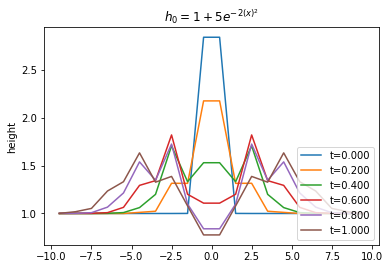

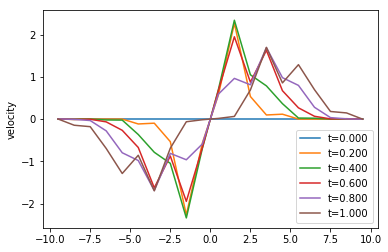

In [120]:
def initial_shallow(x):
    return  numpy.array([1+ 5*(numpy.exp(-((x)*2)**2)),
                        0*x])

x, hist = fvsolve2system(riemann_shallow, initial_shallow, n=20, limit=limit_vl, args=())
pyplot.title('$h_0= 1+ 5e^{-2(x)^2}$')

for t, U in hist:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('height')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')

pyplot.legend(loc='lower right');
pyplot.show()

**Some sonic rarefactions**

Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic
Left rarefaction or shock is supersonic


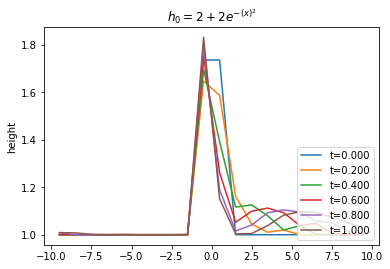

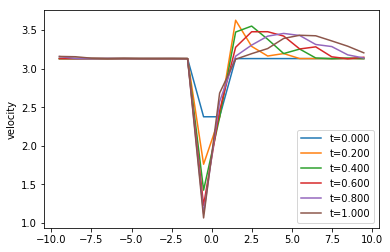

In [129]:
def initial_shallow(x):
    return numpy.array([1+ 2*(numpy.exp(-(x*2)**2)),
                        (9.8000*(1+ 2*(numpy.exp(-(x*2)**2))))**(1./2.)]) 
#sqrt(gh, where h is the conditions defined above)

x, hist = fvsolve2system(riemann_shallow, initial_shallow, n=20, limit=limit_vl, args=())
pyplot.title('$h_0= 1+ 2e^{-(2x)^2}$, v_0= \sqrt(g*h_0)')
for t, U in hist:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('height')
pyplot.legend(loc='lower right');
pyplot.figure()

for t, U in hist:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.ylabel('velocity')

pyplot.legend(loc='lower right');
pyplot.show()

* The total energy in the system is kinetic plus potential energy
$$ E = \int_{\Omega} \frac h 2 u^2 + \frac g 2 h^2 . $$
Compare the evolution of total energy using a first order method and a method using slope reconstruction, for a configuration with a shock and a configuration with only rarefactions.


* Does the result depend on your choice of Riemann solver, e.g., between HLL and Rusanov or between an exact solver and HLL?  Does it depend on your choice of limiter in slope reconstruction?